# Correlated Sine Waves Dataset

This script generates a synthetic dataset consisting of multiple derived sine wave time series. These time series are meant to mimic multiple time series forecasting problems with underlying trends, patterns, noise, anomalies, and changepoints. 

To begin, a seed is set to ensure reproducibility. A base sine wave series is constructed using a combination of a linear trend and a sine function. This base series serves as the foundational pattern for the generation of multiple derived series.

Each derived series is a variation of the base series with:

1. **Trend Variation:** A random scaling of the trend of the base series, mimicking slight variations in the growth or decline trend among the series.
2. **Amplitude Variation:** A random scaling of the amplitude, allowing for series of varying magnitude.
3. **Noise:** Gaussian noise is added to each series, which simulates the day-to-day fluctuations and unpredictabilities commonly found in real-world time series data.
4. **Point Anomalies:** Random point anomalies (spikes or dips) are introduced in some of the time points, replicating unexpected events that might impact the series occasionally.
5. **Changepoints:** In a subset of the series, a sudden level shift is introduced at a random time point, simulating events that cause a significant change in the series level.

The dataset is structured to represent scenarios where multiple time series have underlying correlations due to shared patterns but also have unique characteristics due to individual variations, noise, and anomalies.

The output is a pandas DataFrame with columns representing the series ID, the time step, and the series value at that time step. The series ID gives a unique identifier to each derived series.

The **Correlated Sine Waves Dataset** can be a valuable tool for various purposes:
- **Time Series Forecasting:** Given its structured time dependencies and patterns, it's an excellent dataset for testing and benchmarking time series forecasting models.
- **Anomaly Detection:** With the introduction of point anomalies and noise, the dataset provides a ground to test anomaly detection algorithms.
- **Changepoint Detection:** The intentional introduction of changepoints in some series makes it suitable for testing changepoint detection techniques.

The variability and controlled randomness in the dataset make it mimic real-world challenges, offering a comprehensive testbed for time series analysis methodologies.


In [69]:
import numpy as np
import pandas as pd
from typing import List
import random
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [70]:
dataset_name = "correlated_sine_waves"

In [71]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Functions to generate data

In [72]:
# We aim to create correlated series. So we will create a base series, and then derive the other series from this base series. 
def generate_base_series(t: np.ndarray) -> (np.ndarray, dict):
    """
    Generates the base series using the given time steps.
    
    Args:
    - t (np.ndarray): Array of time steps.
    
    Returns:
    - np.ndarray: Generated base series.
    - dict: Parameters used for base series generation.
    """
    A_base = 5.0
    m_base = 0.05
    a_base = 5
    b_base = 1
    c_base = 0
    
    base_series = A_base * (m_base * t + a_base * np.sin(b_base * t + c_base))
    
    params = {
        'A_base': A_base,
        'm_base': m_base,
        'a_base': a_base,
        'b_base': b_base,
        'c_base': c_base
    }
    
    return base_series, params

(400,)


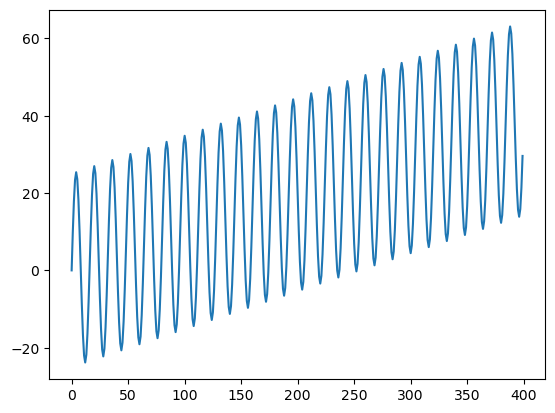

In [73]:
## Plot the base series
t = np.arange(0, 25 * 2 * np.pi, np.pi/8)
ser, params = generate_base_series(t)
print(ser.shape)
plt.plot(ser)
plt.show()

In [74]:
def generate_derived_series(t: np.ndarray, params: dict, num_derived_series: int = 10) -> List[np.ndarray]:
    """
    Generates basic derived series based on the given time steps and parameters from the base series.
    
    Args:
    - t (np.ndarray): Array of time steps.
    - params (dict): Parameters used for base series generation.
    - num_derived_series (int): Number of derived series to generate. Default is 10.
    
    Returns:
    - List[np.ndarray]: List of basic derived series.
    """
    derived_series = []
    
    A_base = params['A_base']
    m_base = params['m_base']
    a_base = params['a_base']
    b_base = params['b_base']
    c_base = params['c_base']

    for _ in range(num_derived_series):
        m = m_base * np.random.uniform(0.8, 1.2)
        A = A_base * np.random.uniform(0.2, 5.0)
        y_temp = A * (m * t + a_base * np.sin(b_base * t + c_base))
        derived_series.append(y_temp)
    
    return derived_series

In [75]:
def add_changepoints_to_series(series_list: List[np.ndarray]) -> List[np.ndarray]:
    """
    Adds changepoints to the provided list of series.
    
    Args:
    - series_list (List[np.ndarray]): List of series to which changepoints will be added.
    
    Returns:
    - List[np.ndarray]: List of series with changepoints.
    """
    num_derived_series = len(series_list)
    # Determine series with changepoints
    series_with_changepoints = np.random.choice(num_derived_series, int(0.2 * num_derived_series), replace=False)

    for i, y_temp in enumerate(series_list):
        if i in series_with_changepoints:
            changepoint_index = np.random.randint(int(0.1 * len(y_temp)), int(0.8 * len(y_temp)))
            shift_factor = np.random.uniform(2.0, 3.0)
            direction = np.random.choice(["up", "down"])            
            if direction == "up":
                # shift up
                # if shift_factor = 2, then shift up by 100% of current mean
                additive_shift = y_temp.mean() * (shift_factor - 1)
            else: 
                # shift down
                # if shift_factor = 2, then shift down by 50% of mean
                additive_shift = - y_temp.mean() * (1 - (1 / shift_factor))
            y_temp[changepoint_index:] += additive_shift            
            #print(i, direction, shift_factor, changepoint_index, additive_shift)

    return series_list

In [76]:
def add_noise_to_series(series_list: List[np.ndarray]) -> List[np.ndarray]:
    """
    Adds noise to the provided list of series.
    
    Args:
    - series_list (List[np.ndarray]): List of series to which noise will be added.
    
    Returns:
    - List[np.ndarray]: List of series with noise.
    """
    for i, y_temp in enumerate(series_list):
        noise = np.random.normal(y_temp.mean(), y_temp.mean()/3, len(y_temp))
        series_list[i] = y_temp + noise
    
    return series_list

In [77]:
def add_anomalies_to_series(series_list: List[np.ndarray]) -> List[np.ndarray]:
    """
    Adds point anomalies to the provided list of series. Excludes last 24 points from anomalies. 
    
    Args:
    - series_list (List[np.ndarray]): List of series to which anomalies will be added.
    
    Returns:
    - List[np.ndarray]: List of series with point anomalies.
    """
    series_len = len(series_list[0])
    for y_temp in series_list:
        num_anomalies = int(0.01 * (series_len - 24))
        anomaly_indices = np.random.choice(series_len - 24, num_anomalies, replace=False)
        for idx in anomaly_indices:
            anomaly_factor = np.random.uniform(0.3, 2.0)
            sign = np.random.choice([1, -1])
            y_temp[idx] += sign * anomaly_factor * y_temp[idx]

    return series_list

# Generate dataset

In [78]:
# Function to conver the timeseries data into required format. 
def create_dataframe(t: np.ndarray, derived_series: List[np.ndarray]) -> pd.DataFrame:
    """
    Creates a DataFrame from the derived series and time steps.
    
    Args:
    - t (np.ndarray): Array of time steps.
    - derived_series (List[np.ndarray]): List of derived series.
    
    Returns:
    - pd.DataFrame: DataFrame with columns series_id, t, and y.
    """
    # Generate IDs for each series
    series_ids = [
        f"series_{i}" for i in range(len(derived_series))
    ]
    df_list = []
    
    for series_id, y in zip(series_ids, derived_series):
        df_temp = pd.DataFrame({
            'series_id': series_id,
            't': t,
            'y': y
        })
        df_list.append(df_temp)

    return pd.concat(df_list, ignore_index=True)

In [79]:
# Update main function
def main(num_derived_series: int = 10) -> pd.DataFrame:
    """
    Orchestrates the generation of base and derived series, structures them into a DataFrame, 
    and visualizes the series.
    
    Args:
    - num_derived_series (int): Number of derived series to generate. Default is 10.
    
    Returns:
    - pd.DataFrame: DataFrame with columns series_id, t, and y.
    """
    # Set random seeds for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    t = np.arange(0, 25 * 2 * np.pi, np.pi/8)
    _, params = generate_base_series(t)
    
    derived_series = generate_derived_series(t, params, num_derived_series)
    derived_series = add_changepoints_to_series(derived_series)
    derived_series = add_noise_to_series(derived_series)
    derived_series = add_anomalies_to_series(derived_series)
    
    df = create_dataframe(t, derived_series)    
    return df

In [80]:
data = main(num_derived_series=20)
print(data.shape)
data.head()

(8000, 3)


,series_id,t,y
0,series_0,0.000000,58.807586
1,series_0,0.392699,87.862930
2,series_0,0.785398,196.562144
3,series_0,1.178097,184.071705
4,series_0,1.570796,169.698217


In [81]:
series_col = "series_id"
epoch_col = 't'
time_col=None
value_col = 'y'
exog_cols=[]

# Visualize Data

In [82]:
def visualize_series(df: pd.DataFrame, filename: str=None, max_series: int=5) -> None:
    """
    Visualizes the series in the provided DataFrame using subplots and saves the plot as a PNG file.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the series data with columns series_id, t, and y.
    - filename (str): Name of the file to save the plot.
    
    Returns:
    - None
    """
    t = df['t'].unique()
    unique_series = sorted(df['series_id'].unique())
    
    fig, axes = plt.subplots(nrows=len(unique_series[:max_series]), ncols=1, figsize=(6, 8), sharex=True)

    for i in range(len(unique_series[:max_series])):
        series_id = f"series_{i}"
        y = df[df['series_id'] == series_id]['y'].values
        axes[i].plot(t, y, label=series_id, color="#1db1c1")
        axes[i].legend(loc="upper left")
        axes[i].grid(True)

    axes[-1].set_xlabel("Time")
    fig.suptitle("Correlated Sine Waves Dataset", y=0.98)
    plt.tight_layout()
    
    # Save the figure
    if filename is not None:
        plt.savefig(filename)
    # Display the plot in Jupyter Notebook
    plt.show()

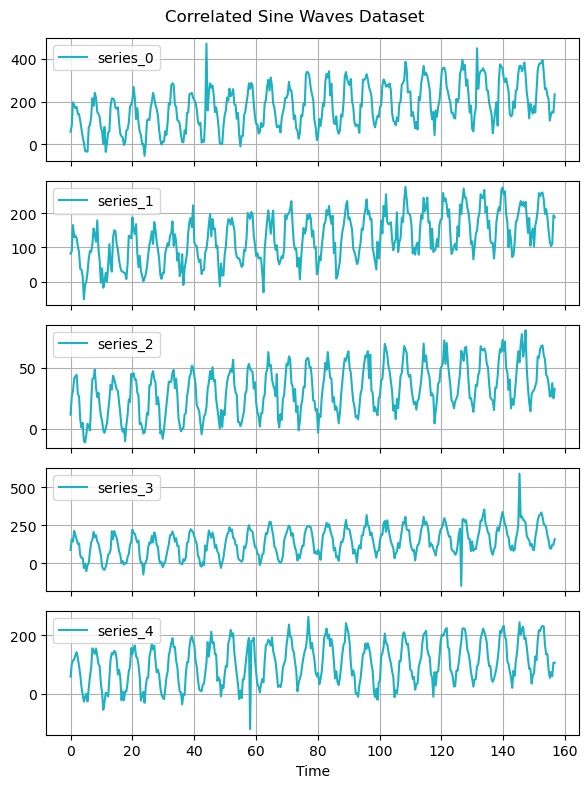

In [83]:
# Visualize
visualize_series(data, outp_fig_fname, max_series=5)

# Save Main Data File

In [84]:
if time_col: 
    all_cols = [series_col, time_col, value_col] + exog_cols
else: 
    all_cols = [series_col, value_col] + exog_cols
    
data.sort_values(by=[series_col, epoch_col], inplace=True)
data[all_cols].to_csv(outp_fname, index=False, float_format='%.3f')